In [25]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

from functools import partial

from nems.signal import load_signals_in_dir
from nems.model import Model
from nems.modules.api import (WeightChannelsGaussian, FIR, DoubleExponential, Sum)

from nems.fitters import scipy
from nems.fitters import pymc3
from nems.fitters import cost_functions

import numpy as np
import pylab as pl
import pymc3 as mc
%matplotlib inline

In [2]:
# Load the data 
signals = load_signals_in_dir('signals/zee021e02_p_RDT')
signals = {k: v.__matrix__ for k, v in signals.items()}
for k, v in signals.items():
    v[np.isnan(v)] = 0

In [9]:
wc = WeightChannelsGaussian(2, 'stim2', 'pred1')
fir = FIR(10, 'pred1', 'pred1')
nonlin = DoubleExponential('pred1', 'pred1', 'resp-c1')

model = Model()
model.append(wc)
model.append(fir)
model.append(nonlin)

In [12]:
cost = partial(cost_functions.mse, pred_name='pred1', resp_name='resp-c1')

result_mean = scipy.fit(model, signals, cost, phi_initialization='mean')
result_s0 = scipy.fit(model, signals, cost, phi_initialization='sample')
result_s1 = scipy.fit(model, signals, cost, phi_initialization='sample')
result_s2 = scipy.fit(model, signals, cost, phi_initialization='sample')
result_median = scipy.fit(model, signals, cost, phi_initialization=0.5)

In [22]:
for r in (result_mean, result_s0, result_s1, result_s2, result_median):
    print(r['result']['fun'])

0.42292736457
0.408384976574
0.416478367972
0.465755217515
0.354062513006


In [34]:
with mc.Model() as m:
    priors = model.get_priors(signals)
    mc_priors = pymc3.construct_priors(priors)

In [23]:
mc_model = pymc3.construct_bayes_model(model, signals, 'pred1', 'resp-c1')

In [26]:
with mc_model:
    result = mc.fit()

Average Loss = 62,955: 100%|██████████| 10000/10000 [05:15<00:00, 31.65it/s]   
Finished [100%]: Average Loss = 62,949


In [44]:
priors = model.get_priors(signals)

In [50]:
def trace_to_phi(trace, priors):
    phi = []
    for module_priors in priors:
        module_phi = {}
        for name in module_priors:
            values = trace.get_values(name)
            module_phi[name] = values.mean(axis=0)
        phi.append(module_phi)
    return phi

In [51]:
trace_to_phi(trace, priors)

[{'mu': array([ 0.60758312,  0.36468497]),
  'sd': array([ 0.37279286,  0.16005052])},
 {'coefficients': array([[ 0.30590762,  0.27865277,  0.23503513,  0.24565239,  0.21558226,
           0.23014794,  0.27455101,  0.38251365,  0.58047128,  0.92450239],
         [ 0.41705449,  0.35513819,  0.30600149,  0.32530628,  0.33642932,
           0.31333275,  0.44818655,  0.655875  ,  0.91868403,  1.2415622 ]])},
 {'amplitude': 0.42450405167211486,
  'base': 0.024544490019519073,
  'kappa': 0.0020251525289651587,
  'shift': 552.04434438161422}]

In [53]:
mc.fit?

In [28]:
trace = result.sample(5000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e3d1826d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4e519612b0>]], dtype=object)

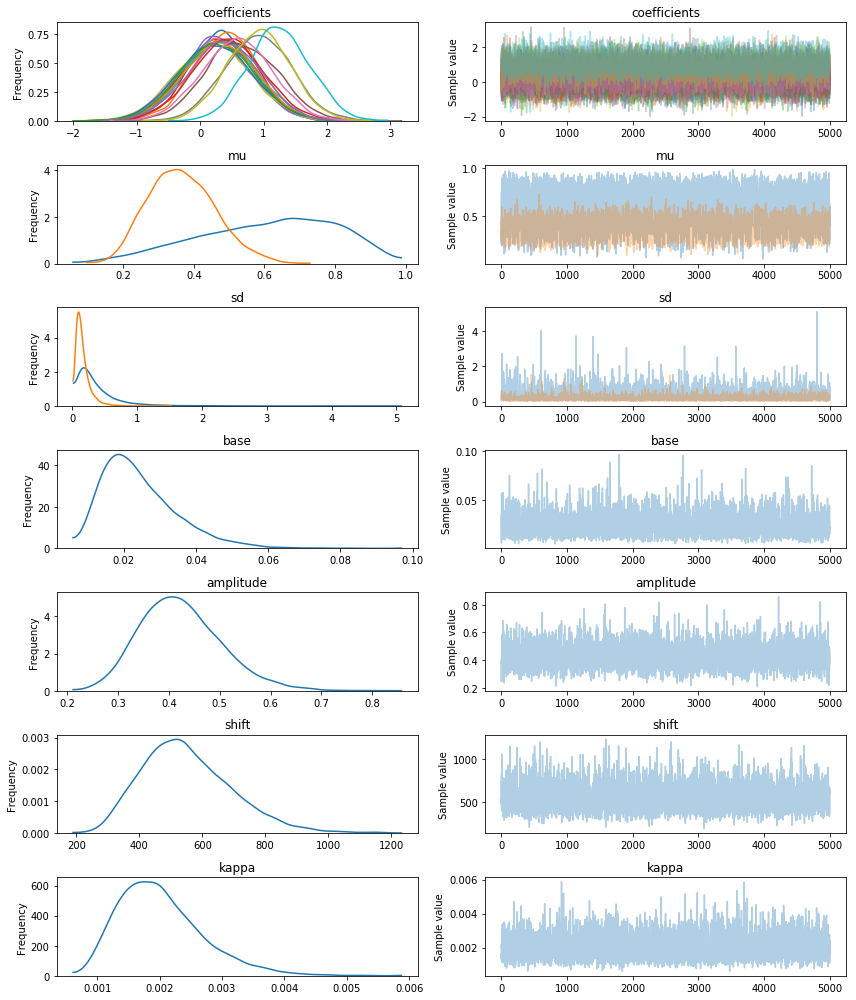

In [42]:
mc.traceplot(trace)

In [69]:
from nems.fitters.util import phi_percentile, initialize_phi

In [57]:
    >>> from nems.distributions.api import Normal, Beta
    >>> beta_a = [[1, 2, 3], [1, 2, 3]]
    >>> beta_b = [[1, 2, 3], [3, 2, 1]]
    >>> priors = [{'mu': Normal([0, 5], [0.5, 0.5])}, {'scale': Beta(beta_a, beta_b)}]
    >>> lower_bound = phi_percentile(priors, 0)
    >>> upper_bound = phi_percentile(priors, 1)


In [59]:
print(upper_bound)

[{'mu': array([ inf,  inf])}, {'scale': array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])}]


In [60]:
    >>> from nems.distributions.api import Normal, Beta
    >>> beta_a = [[1, 2], [1, 2]]
    >>> beta_b = [[1, 2], [3, 2]]
    >>> priors = [{'mu': Normal([0, 5])}, {'scale': Beta(beta_a, beta_b)}]

    >>> lower_bound = phi_percentile(priors, 0)
    >>> upper_bound = phi_percentile(priors, 1)


TypeError: __init__() missing 1 required positional argument: 'sd'

In [61]:
    >>> from nems.distributions.api import Normal, Beta
    >>> beta_a = [[1, 2], [1, 2]]
    >>> beta_b = [[1, 2], [3, 2]]
    >>> priors = [{'mu': Normal(0, 0.5)},
                  {'scale': Beta(beta_a, beta_b)}]
    >>> lower_bound = phi_percentile(priors, 0)
    >>> upper_bound = phi_percentile(priors, 1)


In [63]:
print(lower_bound)

[{'mu': -inf}, {'scale': array([[ 0.,  0.],
       [ 0.,  0.]])}]


In [64]:
phi_percentile(priors, 0.5)

[{'mu': 0.0}, {'scale': array([[ 0.5       ,  0.5       ],
         [ 0.20629947,  0.5       ]])}]

In [67]:
    >>> from nems.distributions.api import Normal, Beta
    >>> beta_a = [[1, 2], [1, 2]]
    >>> beta_b = [[1, 2], [3, 2]]
    >>> priors = [{'mu': Normal(0, 0.5)},
                  {'scale': Beta([1, 2], [2, 1])}]

    >>> lower_bound = phi_percentile(priors, 0)
    >>> print(lower_bound)

    >>> upper_bound = phi_percentile(priors, 1)
    >>> print(upper_bound)


[{'mu': -inf}, {'scale': array([ 0.,  0.])}]
[{'mu': inf}, {'scale': array([ 1.,  1.])}]


In [68]:
print(phi_percentile(priors, 0.5))

[{'mu': 0.0}, {'scale': array([ 0.29289322,  0.70710678])}]


In [70]:
initialize_phi(priors, 'mean')

[{'mu': 0.0}, {'scale': array([ 0.33333333,  0.66666667])}]

In [71]:
i = print
i('foo')

foo
